<a href="https://colab.research.google.com/github/hflautert/AnomalyDetection/blob/main/AnomaliaICMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experimento de reconhecimento de anomalias em ataque DoS do tipo ICMP.

Fonte de dados:

Rede normal:
https://iotanalytics.unsw.edu.au/anomaly-data/pcap/benign/18-05-31.pcap

Rede com ataques:
https://iotanalytics.unsw.edu.au/anomaly-data/pcap/AttackAndBenign/18-06-02.pcap

Descrição dos ataques:
https://iotanalytics.unsw.edu.au/anomaly-data/attackinfo.xlsx

Para gerar as estatísticas, os arquivos foram abertos com WireShark, aplicado filtro `icmp`. Posteriormente gerado dados no menu Statistics, I/O Graph, salvo como csv, nos intervalos de 1 minuto, 10 segundos, e 1 segundo.

Ataques ICMP contabilizados com WireShark = [22](https://github.com/hflautert/AnomalyDetection/blob/main/Prints/WS_ICMP_n.PNG).

In [ ]:
# Importando bibliotecas
# Manipulação de matrizes e operações matemáticas de alto nível
import numpy as np
# Geração de gráficos
import matplotlib.pyplot as plt

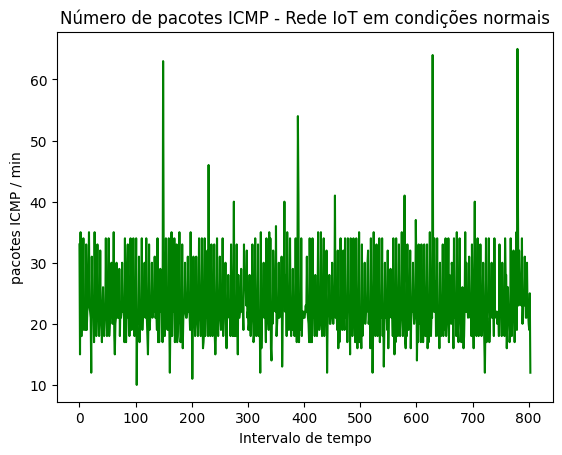

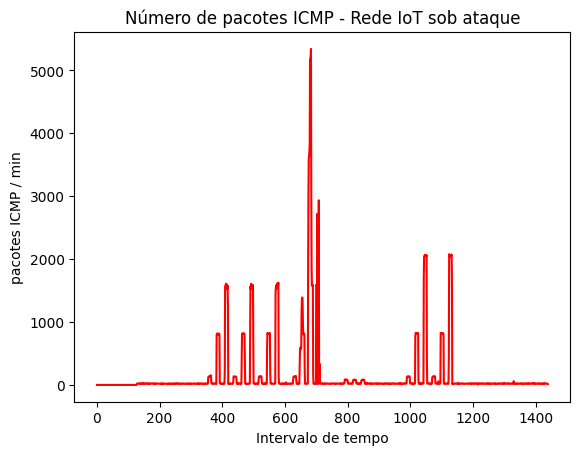

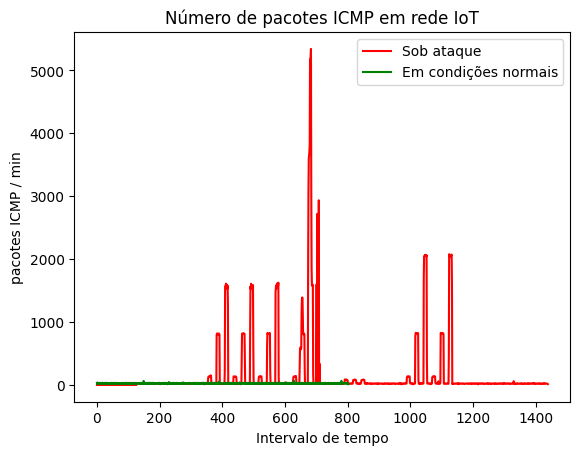

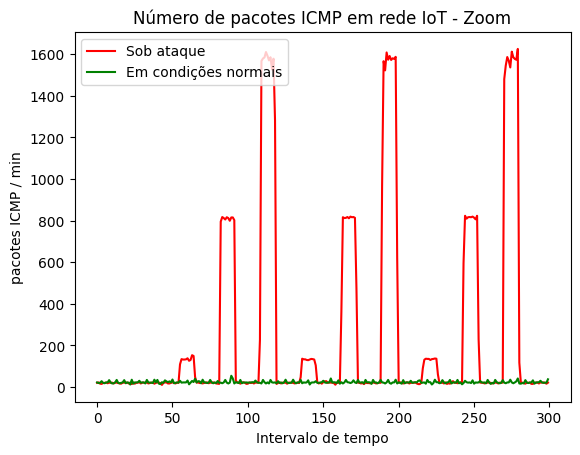

In [ ]:
# Carregando dados

a1m = "https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_icmp_1m.csv"
a10s = "https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_icmp_10s.csv"
a1s = "https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_icmp_1s.csv"

b1m = "https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_icmp_1m.csv"
b10s = "https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_icmp_10s.csv"
b1s = "https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_icmp_1s.csv"

dados_ataque_1m = np.loadtxt(a1m, delimiter=',',skiprows=1)
dados_ataque_10s = np.loadtxt(a10s, delimiter=',',skiprows=1)
dados_ataque_1s = np.loadtxt(a1s, delimiter=',',skiprows=1)

dados_normal_1m = np.loadtxt(b1m, delimiter=',',skiprows=1)
dados_normal_10s = np.loadtxt(b10s, delimiter=',',skiprows=1)
dados_normal_1s = np.loadtxt(b1s, delimiter=',',skiprows=1)

#Somente a coluna de dados
dados_normal_1m = dados_normal_1m[:, 1]
dados_ataque_1m = dados_ataque_1m[:, 1]

dados_normal_10s = dados_normal_10s[:, 1]
dados_ataque_10s = dados_ataque_10s[:, 1]

dados_normal_1s = dados_normal_1s[:, 1]
dados_ataque_1s = dados_ataque_1s[:, 1]

# Condicoes normais
plt.plot(dados_normal_1m, color = 'g')
plt.title('Número de pacotes ICMP - Rede IoT em condições normais')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes ICMP / min')
plt.show()

# Sob ataque
plt.plot(dados_ataque_1m, color = 'r')
plt.title('Número de pacotes ICMP - Rede IoT sob ataque')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes ICMP / min')
plt.show()

# Unindo linhas
plt.plot(dados_ataque_1m, color = 'r', label = "Sob ataque")
plt.plot(dados_normal_1m, color = 'g', label = "Em condições normais")
plt.title('Número de pacotes ICMP em rede IoT')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes ICMP / min')
plt.legend()
plt.show()

# Vizualização otimizada com zoom na janela de ataque de 1, 10 e 100 pcts/s
v_dados_normal_1m = dados_normal_1m[300:600]
v_dados_ataque_1m = dados_ataque_1m[300:600]

# Unindo linhas
plt.plot(v_dados_ataque_1m, color = 'r', label = "Sob ataque")
plt.plot(v_dados_normal_1m, color = 'g', label = "Em condições normais")
plt.title('Número de pacotes ICMP em rede IoT - Zoom')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes ICMP / min')
plt.legend()
plt.show()


In [ ]:
# Carregando dados completos 1m
pkts_ICMP = dados_ataque_1m
pkts_ICMP_n = dados_normal_1m

# Variaveis do modelo
# Crescimento no nº de pacotes
delta_v=1.1
# Tamanho da janela histórica para media movel
hist_mm=10
# Taxa mínima para considerar ICMP
min_ICMP=20

v = np.lib.stride_tricks.sliding_window_view(pkts_ICMP,hist_mm)
vn = np.lib.stride_tricks.sliding_window_view(pkts_ICMP_n,hist_mm)

cont_ataque = 0
cont_f_ataque = 0
sob_ataque = 0

for i in range(len(v)):
  if i<2: #sem base para comparacao
    #print ("menor q 2")
    pass
  else:
    #print("---")
    #print("antepenultima",v[i-2].mean())
    antpen_media=v[i-2].mean()
    #print("penultima",v[i-1].mean())
    pen_media=v[i-1].mean()
    #print("media atual",v[i].mean())
    media_atual=v[i].mean()
    if (antpen_media<min_ICMP) and (pen_media<min_ICMP) and (media_atual<min_ICMP):
      pass # taxa mínima
    else:
      if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
        #print ("Crescimento de x% nas ultimas 3 medicoes")
        cont_ataque += 1
        sob_ataque = 1
        #print("i:",i)
        #print (antpen_media,pen_media,media_atual)
      if (antpen_media>pen_media) and (pen_media>media_atual):
        #print ("Media em queda, desarma sob ataque")
        sob_ataque = 0

print ("Total de ataques identificados:",cont_ataque)
# crescimento de x% nos erros das ultimas 3 medias
# sob-ataque: ignora novos crescimentos - mesmo ataque
# desarma sob-ataque com queda nas ultimas 3 medias.

sob_ataque = 0

for i in range(len(vn)):
  if i<2: #sem base para comparacao
    pass
  else:
    antpen_media=vn[i-2].mean()
    pen_media=vn[i-1].mean()
    media_atual=vn[i].mean()
    if (antpen_media<min_ICMP) and (pen_media<min_ICMP) and (media_atual<min_ICMP):
      pass # taxa mínima
    else:
      if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
       cont_f_ataque += 1
       sob_ataque = 1
       #print (antpen_media,pen_media,media_atual)
      if (antpen_media>pen_media) and (pen_media>media_atual):
        sob_ataque = 0

print ("Falsos positivos:",cont_f_ataque)

Total de ataques identificados: 22
Falsos positivos: 0


In [ ]:
# Carregando dados completos 10s

pkts_ICMP = dados_ataque_10s
pkts_ICMP_n = dados_normal_10s

# Variaveis do modelo
# Crescimento no nº de pacotes
delta_v=1.10
# Tamanho da janela histórica para media movel
hist_mm=30
# Taxa mínima para considerar ICMP
min_ICMP=2

v = np.lib.stride_tricks.sliding_window_view(pkts_ICMP,hist_mm)
vn = np.lib.stride_tricks.sliding_window_view(pkts_ICMP_n,hist_mm)

cont_ataque = 0
cont_f_ataque = 0
sob_ataque = 0

for i in range(len(v)):
  if i<2: #sem base para comparacao
    #print ("menor q 2")
    pass
  else:
    #print("---")
    #print("antepenultima",v[i-2].mean())
    antpen_media=v[i-2].mean()
    #print("penultima",v[i-1].mean())
    pen_media=v[i-1].mean()
    #print("media atual",v[i].mean())
    media_atual=v[i].mean()
    if (antpen_media<min_ICMP) and (pen_media<min_ICMP) and (media_atual<min_ICMP):
      pass # taxa mínima
    else:
      if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
        #print ("Crescimento de x% nas ultimas 3 medicoes")
        cont_ataque += 1
        sob_ataque = 1
        #print("i:",i)
        #print (antpen_media,pen_media,media_atual)
      if (antpen_media>pen_media) and (pen_media>media_atual):
        #print ("Media em queda, desarma sob ataque")
        sob_ataque = 0

print ("Total de ataques identificados:",cont_ataque)
# crescimento de x% nos erros das ultimas 3 medias
# sob-ataque: ignora novos crescimentos - mesmo ataque
# desarma sob-ataque com queda nas ultimas 3 medias.

sob_ataque = 0

for i in range(len(vn)):
  if i<2: #sem base para comparacao
    pass
  else:
    antpen_media=vn[i-2].mean()
    pen_media=vn[i-1].mean()
    media_atual=vn[i].mean()
    if (antpen_media<min_ICMP) and (pen_media<min_ICMP) and (media_atual<min_ICMP):
      pass # taxa mínima
    else:
      if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
       cont_f_ataque += 1
       sob_ataque = 1
       #print (antpen_media,pen_media,media_atual)
      if (antpen_media>pen_media) and (pen_media>media_atual):
        sob_ataque = 0

print ("Falsos positivos:",cont_f_ataque)

Total de ataques identificados: 22
Falsos positivos: 0


In [ ]:
# Carregando dados completos 1s

pkts_ICMP = dados_ataque_1s
pkts_ICMP_n = dados_normal_1s

# Variaveis do modelo
# Crescimento no nº de pacotes
delta_v=1.03
# Tamanho da janela histórica para media movel
hist_mm=55
# Taxa mínima para considerar ICMP
min_ICMP=2

v = np.lib.stride_tricks.sliding_window_view(pkts_ICMP,hist_mm)
vn = np.lib.stride_tricks.sliding_window_view(pkts_ICMP_n,hist_mm)

cont_ataque = 0
cont_f_ataque = 0
sob_ataque = 0

for i in range(len(v)):
  if i<2: #sem base para comparacao
    #print ("menor q 2")
    pass
  else:
    #print("---")
    #print("antepenultima",v[i-2].mean())
    antpen_media=v[i-2].mean()
    #print("penultima",v[i-1].mean())
    pen_media=v[i-1].mean()
    #print("media atual",v[i].mean())
    media_atual=v[i].mean()
    if (antpen_media<min_ICMP) and (pen_media<min_ICMP) and (media_atual<min_ICMP):
      pass # taxa mínima
    else:
      if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
        #print ("Crescimento de x% nas ultimas 3 medicoes")
        cont_ataque += 1
        sob_ataque = 1
        #print("i:",i)
        #print (antpen_media,pen_media,media_atual)
      if (antpen_media>pen_media) and (pen_media>media_atual):
        #print ("Media em queda, desarma sob ataque")
        sob_ataque = 0

print ("Total de ataques identificados:",cont_ataque)
# crescimento de x% nos erros das ultimas 3 medias
# sob-ataque: ignora novos crescimentos - mesmo ataque
# desarma sob-ataque com queda nas ultimas 3 medias.

sob_ataque = 0

for i in range(len(vn)):
  if i<2: #sem base para comparacao
    pass
  else:
    antpen_media=vn[i-2].mean()
    pen_media=vn[i-1].mean()
    media_atual=vn[i].mean()
    if (antpen_media<min_ICMP) and (pen_media<min_ICMP) and (media_atual<min_ICMP):
      pass # taxa mínima
    else:
      if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
       cont_f_ataque += 1
       sob_ataque = 1
       #print (antpen_media,pen_media,media_atual)
      if (antpen_media>pen_media) and (pen_media>media_atual):
        sob_ataque = 0

print ("Falsos positivos:",cont_f_ataque)

Total de ataques identificados: 22
Falsos positivos: 0
